In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import uncertainty_toolbox as uct

from utils import savefig

In [2]:
import pathlib as pl
import candas as can

code_pth = pl.Path.cwd()  # for running in Jupyter
# code_pth = pl.Path(__file__)  # for running in terminal
fig_pth = code_pth.parent
data_pth = fig_pth / "data"
graph_pth = fig_pth / "graphics"
graph_pth.mkdir(exist_ok=True)

gen_pth = fig_pth / "generated"
gen_pth.mkdir(exist_ok=True)

plt.style.use(str(can.style.breve))



In [17]:
ticklabelsize = 6
labelsize = 8
titlesize = labelsize + 2

plt.rcParams["lines.linewidth"] = 1
plt.rcParams["axes.linewidth"] = 0.5
plt.rcParams["grid.linewidth"] = 0.25
plt.rcParams["font.size"] = labelsize
plt.rcParams["axes.titlesize"] = titlesize
plt.rcParams["axes.labelsize"] = labelsize
plt.rcParams["xtick.labelsize"] = ticklabelsize
plt.rcParams["ytick.labelsize"] = ticklabelsize
plt.rcParams["xtick.major.size"] = 1.5
plt.rcParams["ytick.major.size"] = 1.5
plt.rcParams["xtick.major.width"] = 0.5
plt.rcParams["ytick.major.width"] = 0.5
plt.rcParams["legend.fontsize"] = labelsize
plt.rcParams["legend.title_fontsize"] = labelsize
plt.rcParams["figure.titlesize"] = titlesize

In [18]:
qq_avg = pd.read_csv(gen_pth / "Avg_model_qq.csv")
qq_ind = pd.read_csv(gen_pth / "Ind_model_qq.csv")
qq_lmc_pr = pd.read_csv(gen_pth / "LMC_model_qq.csv")
qq = pd.concat([qq_avg.assign(
    Model="Average",
), qq_ind.assign(
    Model="Individual",
), qq_lmc_pr.assign(
    Model="LMC_pr",
)], axis=0)

if (gen_pth / "LMC_model2_qq.csv").exists():
    qq_lmc_p = pd.read_csv(gen_pth / "LMC_model2_qq.csv")
    qq = pd.concat([qq, qq_lmc_p.assign(
        Model="LMC_p",
    )], axis=0)
    
qq = qq.rename(columns={
    "N_train": "N Training Points",
    'Train_pred_q': 'Expected Proportion',
    'Train_obsd_q': 'Observed Proportion',
}).reset_index(drop=True)

Saving fig_S7B__wet_iguana in /home/john/projects/can-manuscript/fig_S7__high_gecko/graphics: [.svg] [.png] done


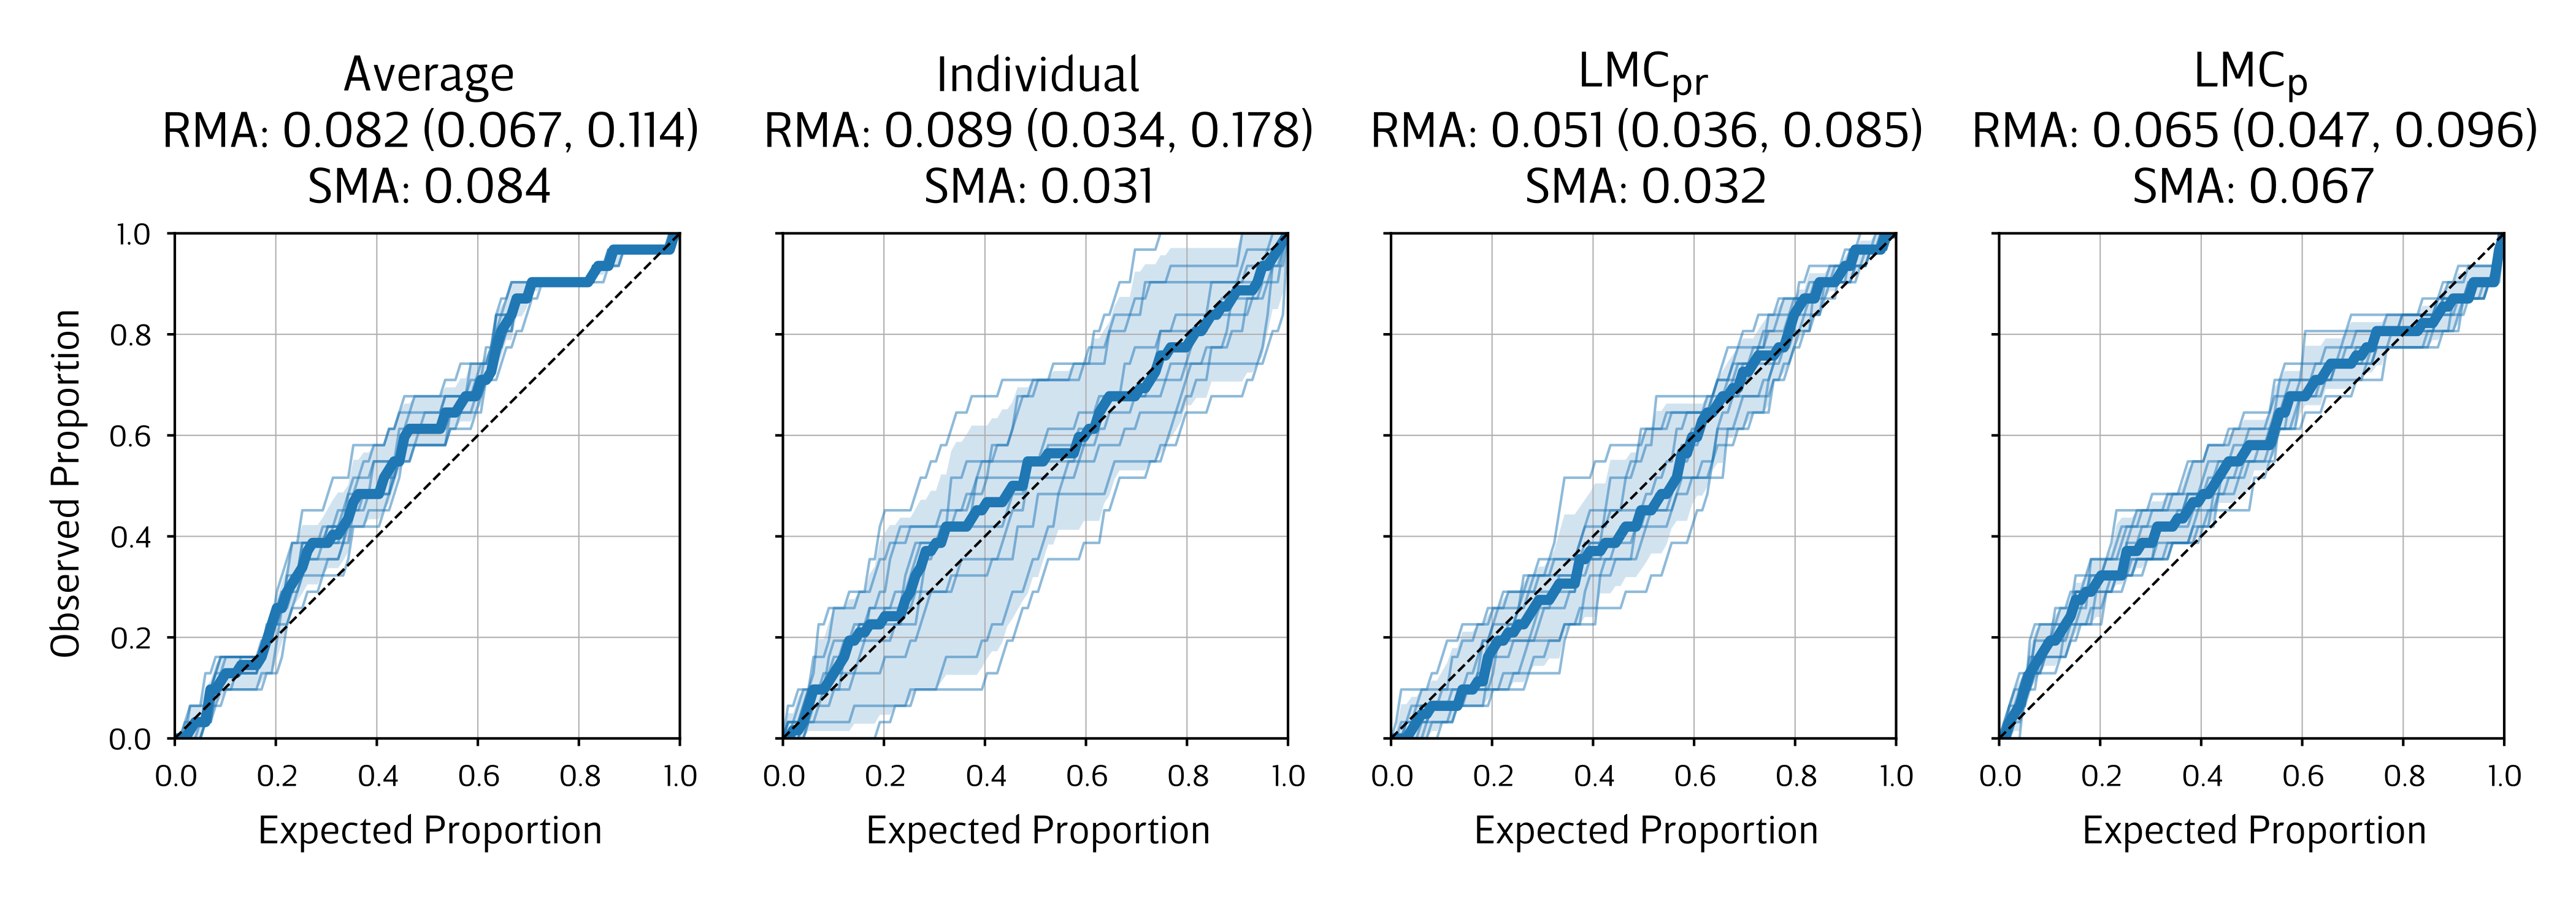

In [21]:
Models = qq["Model"].unique()
n_m = len(Models)
fig, axs = plt.subplots(1, n_m, figsize=(7, 2.5), sharex=True, sharey=True)

for ax, Model in zip(axs.flat, Models):

    miscals = []
    data = qq[qq["Model"] == Model].reset_index(drop=True)
    for i in data.Iteration.unique():
        data_i = data[data["Iteration"] == i]
        ax.plot(
            data_i["Expected Proportion"],
            data_i["Observed Proportion"],
            color="C0",
            alpha=0.5,
            linewidth=0.5,
        )

        miscals.append(
            uct.metrics_calibration.miscalibration_area_from_proportions(
                exp_proportions=data_i["Expected Proportion"].values,
                obs_proportions=data_i["Observed Proportion"].values,
            )
        )

    grpd_obs = data.groupby("Expected Proportion")["Observed Proportion"]
    l, m, u = [grpd_obs.quantile(q) for q in [0.05, 0.5, 0.95]]
    ax.plot(
        data_i["Expected Proportion"],
        m,
        color="C0",
        linewidth=2,
        label="Median",
    )
    ax.fill_between(
        data_i["Expected Proportion"],
        l,
        u,
        color="C0",
        alpha=0.2,
        label="5-95% quantiles",
        edgecolor="none",
    )
    ax.plot([0, 1], [0, 1], color="k", linestyle="--", linewidth=0.5)
    
    l_of_mis, m_of_mis, u_of_mis = np.quantile(np.stack(miscals), [0.05, 0.5, 0.95], axis=-1)
    mis_of_l, mis_of_m, mis_of_u = [uct.metrics_calibration.miscalibration_area_from_proportions(
        exp_proportions=data_i["Expected Proportion"].values,
        obs_proportions=mis.values,
    ) for mis in [l, m, u]]


    model = Model.replace("_pr", "$_{pr}$").replace("_p", "$_{p}$")
    ax.set_title(f"{model}\n"
                 f"RMA: {m_of_mis:.3f} ({l_of_mis:.3f}, {u_of_mis:.3f})\n"
                 f"SMA: {mis_of_m:.3f}",
                 fontsize=titlesize)
    ax.grid(True)
    ax.set_ylim(0, 1)
    ax.set_xlim(0, 1)
    ax.set_aspect("equal")
    ax.set_xlabel("Expected Proportion")
    
axs[0].set_ylabel("Observed Proportion")

plt.tight_layout()
savefig(plt.gcf(), alias="wet_iguana")